In [39]:
import os
import json
import argparse

import pandas as pd
import seaborn as sns

from tqdm import tqdm_notebook

import sys
sys.path.append('/home/yangz2/projects/gmvae_and_gmmvae/pytorch/')
from model.GMVAE import *

In [2]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=100,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=1,
                    help='number of classes (default: 10)')  # edited for this task
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=3072, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=0.9, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

In [3]:
def softplus(pre_vars):
    return np.log(1 + np.e ** pre_vars)

In [4]:
def save_mus_and_vars(gmvae, num_components):
    
    mus_s, vars_s = [], []

    for class_idx in range(num_components):
        
        zeros = torch.zeros((1, num_components))
        zeros[0][class_idx] = 1
        mus = gmvae.network.generative.y_mu(zeros.cuda()).detach().squeeze().cpu().numpy()
        vars = gmvae.network.generative.y_var(zeros.cuda()).detach().squeeze().cpu().numpy()

        mus_s.append(mus); vars_s.append(vars)

    mus_s, vars_s = np.array(mus_s), softplus(np.array(vars_s))
    
    assert mus_s.shape == (num_components, 64) == vars_s.shape
    
    with open(f'smba_{num_components}.json', 'w+') as json_f:
        json.dump({'mus_s':mus_s.tolist(), 'vars_s':vars_s.tolist()}, json_f)

In [5]:
comps_to_test = np.arange(2, 9).tolist() + [28, 48, 68, 108, 128]
comps_to_test

[2, 3, 4, 5, 6, 7, 8, 28, 48, 68, 108, 128]

In [7]:
for i in tqdm_notebook(comps_to_test):
    args.num_classes = i
    gmvae = GMVAE(args)
    gmvae.network.load_state_dict(torch.load(f'../smba_gmvae_{i}/smba_gmvae.pth'))
    save_mus_and_vars(gmvae, i)

## Compute distances

In [16]:
# def kl_divergence(mu1, mu2, sigma_1, sigma_2):

#     sigma_diag_1 = np.eye(sigma_1.shape[0]) * sigma_1
#     sigma_diag_2 = np.eye(sigma_2.shape[0]) * sigma_2

#     sigma_diag_2_inv = np.linalg.inv(sigma_diag_2)

#     kl = 0.5 * (np.log(np.linalg.det(sigma_diag_2) / np.linalg.det(sigma_diag_2))
#                 - mu1.shape[0] + np.trace(np.matmul(sigma_diag_2_inv, sigma_diag_1))
#                 + np.matmul(np.matmul(np.transpose(mu2 - mu1), sigma_diag_2_inv), (mu2 - mu1))
#                 )

#     return kl

In [9]:
min_norms = []
max_norms = []
norms_s = []
spreads_s = []
comps = []

os.chdir('.')

for num_components in tqdm_notebook(comps_to_test):
    
    with open(f'smba_{num_components}.json', 'r') as json_f:
        learned_params = json.load(json_f)
        mus_s, stds_s = np.array(learned_params['mus_s']), np.array(learned_params['vars_s']) ** 0.5
        
    norms = []
    spreads = []
            
    for i in range(num_components):
        for j in range(num_components):
            if (j > i):
                
#                 norms.append(np.linalg.norm(mus_s[i] - mus_s[j]))
                
                spreads.append(np.mean((stds_s[i] + stds_s[j]) * 0.5))
    
                norms.append(
                    np.mean(
                        ((stds_s[i] + stds_s[j]) * 0.5) / np.abs(mus_s[i] - mus_s[j])
                    )
                )
#                 klds.append(kl_divergence(mus_s[i], mus_s[j], stds_s[i], stds_s[j]))
                
    spreads_s.extend(spreads)
    norms_s.extend(norms)
    comps.extend([num_components] * len(norms))
    
    min_norms.append(np.min(norms))
    max_norms.append(np.max(norms))
    
norms_s = np.array(norms_s).reshape(-1, 1)
spreads_s = np.array(spreads_s).reshape(-1, 1)
comps = np.array(comps).reshape(-1, 1)
min_norms = np.array(min_norms)
max_norms = np.array(max_norms)

In [10]:
df = pd.DataFrame(np.hstack([norms_s, spreads_s, comps]))
df.columns = ['distance', 'spread', 'num_components']
min = df['distance'].min()
df['distance'] /= min

In [11]:
df.head()

,distance,spread,num_components
0,17.245633,0.834143,2.0
1,9.029140,0.829442,3.0
2,7.777382,0.833035,3.0
3,15.412762,0.835517,3.0
4,13.855405,0.806799,4.0


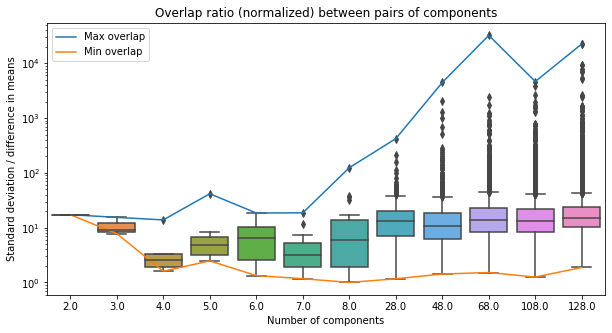

In [67]:
plt.figure(figsize=(10, 5))

sns.boxplot(x='num_components', y='distance', data=df)
plt.yscale('log')
plt.plot(max_norms / min, label='Max overlap')
plt.plot(min_norms / min, label='Min overlap')

plt.xlabel('Number of components')
plt.ylabel('Standard deviation / difference in means')
plt.title('Overlap ratio (normalized) between pairs of components')
plt.legend()

plt.savefig('Overlap ratio between pairs of components.png')

## Project samples using t-SNE

In [29]:
generations_s = []
comp_idxs_s = []

for i in tqdm_notebook(comps_to_test):
    args.num_classes = i
    gmvae = GMVAE(args)
    gmvae.network.load_state_dict(torch.load(f'../smba_gmvae_{i}/smba_gmvae.pth'))
    
    num_for_tsne = 2000
    generations_s.append(gmvae.random_generation(num_elements=2000 // i))
    comp_idxs_s.append(np.repeat(np.arange(1, i+1), 2000 // i))

In [32]:
generations_s[0].shape, comp_idxs_s[0].shape

((2000, 3072), (2000,))

In [36]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA



# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm

# tsne_features = TSNE(n_components=2).fit_transform(test_features[:first_n])

In [37]:
pca_50 = PCA(n_components=50)

In [38]:
tsne_features_s = []
for generations in tqdm_notebook(generations_s):
    # reference: https://www.datacamp.com/community/tutorials/introduction-t-sne
    pca_out = pca_50.fit_transform(generations)  # speed up TSNE drastically
    tsne_features = TSNE(n_components=2).fit_transform(pca_out)
    tsne_features_s.append(tsne_features)

In [40]:
with open('tsne_features_s.json', 'w+') as json_f:
    json.dump([i.tolist() for i in tsne_features_s], json_f)

In [41]:
with open('tsne_features_s.json', 'r') as json_f:
    tsne_features_s = [np.array(i) for i in json.load(json_f)]

In [47]:
X, Y = np.s_[:,0], np.s_[:,1]

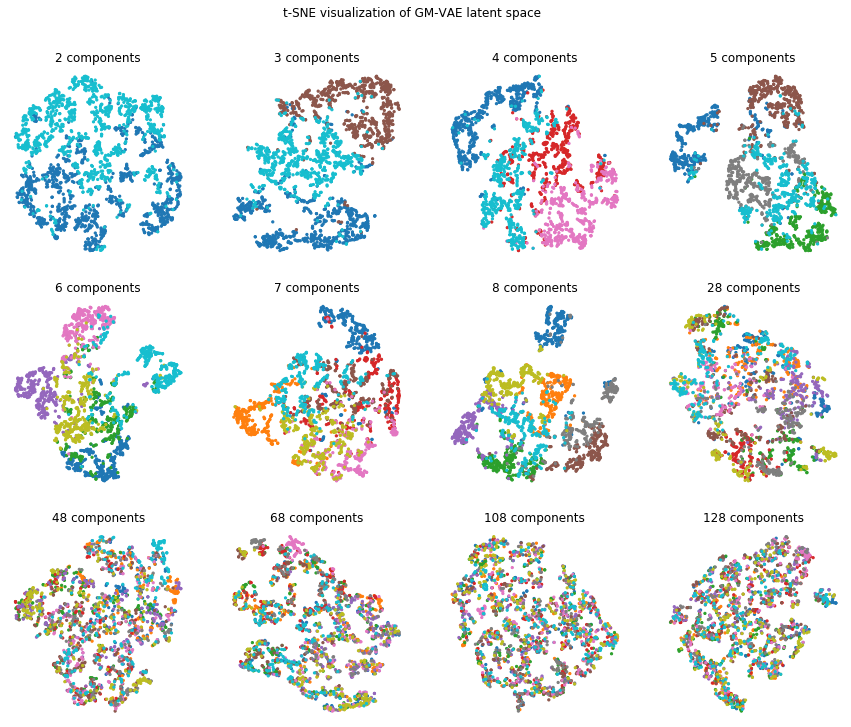

In [68]:
fig, axs = plt.subplots(3, 4, figsize=(15, 12))
axs = axs.flatten()
for i, (comp_idxs, tsne_features) in enumerate(zip(comp_idxs_s, tsne_features_s)):
    axs[i].set_title(f"{comps_to_test[i]} components")
    axs[i].scatter(tsne_features[X], tsne_features[Y], c=comp_idxs, s=5, cmap='tab10')
    axs[i].axis('off')
plt.suptitle('t-SNE visualization of GM-VAE latent space', y=0.95)
plt.savefig('t-SNE visualization of GM-VAE latent space.png')